# Final Analysis of NEH Grant Data: 1966-2023

***

* **Author:** [Lucy Havens](https://lucyhavens.com)
* **Due Date:** September 16, 2023
* **Data source:** [Data.gov](https://catalog.data.gov/organization/neh-gov)
* **Aim:** Convey something of note about humanities or NEH grantmaking, demonstrating technical savvy, communication skills, and humanities literacy

***

**Contents**

[I.](#data) Data Loading

[II.](#quant) Quantities

[III.](#text) Text Analysis

***

Import programming libraries:

In [27]:
# For custom functions:
import utils

# For XML data:
import xml.etree.ElementTree as ET

# For text data:
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# For tabular data
import pandas as pd

# For creating directories
from pathlib import Path

# For visualizing data
import matplotlib.pyplot as plt

# For exporting data
import json

[nltk_data] Downloading package stopwords to /Users/lucy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<a id="data"></a>
## I. Data Loading

Import the XML data files of NEH grants from the 1960s through the 2020s:

In [2]:
datadir = "neh-data/"
year_list = [1960, 1970, 1980, 1990, 2000, 2010, 2020]
titles, years, descriptions, organizations, disciplines = [], [], [], [], []

Extract the text for the following data fields from each decade's grant data:
* Project title (`<ProjectTitle>...</ProjectTitle>`)
* Year project awarded grant (`<YearAwarded>...</YearAwarded>`)
* Project description (`<ProjectDesc>...</ProjectDesc>`)
* Organization type (`<OrganizationType>...</OrganizationType>`)
* Primary discipline (`<PrimaryDiscipline>...</PrimaryDiscipline>`)

In [3]:
for y in year_list:
    filepath = datadir+"NEH_Grants{year}s/NEH_Grants{year}s.xml".format(year=y)
    tree = ET.parse(filepath)
    root = tree.getroot()
    titles = titles + utils.getTextBeneathTag(root, "ProjectTitle")
    years = years + utils.getTextBeneathTag(root, "YearAwarded")
    descriptions = descriptions + utils.getTextBeneathTag(root, "ProjectDesc")
    organizations = organizations + utils.getTextBeneathTag(root, "OrganizationType")
    disciplines = disciplines + utils.getTextBeneathTag(root, "PrimaryDiscipline")

Transform the year data from strings to integers (a.k.a. represent the years as numbers rather than text):

In [4]:
grant_years = [int(year) for year in years]

Ensure all lists are the same length (there should be one list item per project in every list):

In [5]:
assert len(titles) == len(descriptions), "There should be the same number of retrieved titles and descriptions."
assert len(titles) == len(organizations), "There should be the same number of retrieved titles and organizations."
assert len(disciplines) == len(organizations), "There should be the same number of retrieved disciplines and organizations."
assert len(years) == len(disciplines), "There should be the same number of retrieved years as disciplines."

In [6]:
print("Total projects:", len(titles))
print("First grant year:", min(grant_years))
print("Last grant year:", max(grant_years))

Total projects: 68798
First grant year: 1966
Last grant year: 2023


<a id="quant"></a>
## II. Quantities

Create a table (specifically a *DataFrame*, a type of data structure in [pandas](pandas.pydata.org)) with the year, title, organization, and discipline data:

In [7]:
df = pd.DataFrame({"YearAwarded":grant_years, "ProjectTitle":titles, 
                   "OrganizationType":organizations, "PrimaryDiscipline":disciplines})
# Sort ascending by year, then title, then organization type, then discipline
df = df.sort_values(by=["YearAwarded","ProjectTitle","OrganizationType","PrimaryDiscipline"])
# Ensure no data was missed
assert df.shape[0] == len(disciplines), "There should be the same number of DataFrame rows as retrieved list items"
# View the initial rows of the DataFrame
df.head()

,YearAwarded,ProjectTitle,OrganizationType,PrimaryDiscipline
431,1966,A Project for Creation of Source Materials in ...,Center For Advanced Study/Research Institute,U.S. History
585,1966,Conference to Analyze Present Situation of Lat...,Four-Year College,Classical Languages
873,1966,Ming Biographical History Project,Center For Advanced Study/Research Institute,East Asian History
47,1966,Summer institute in papyrology to be conducted...,Professional Association,Ancient Literature
414,1966,Support of Standard Editions of American Authors,Center For Advanced Study/Research Institute,"Literature, General"


Calculate the sum of grants awarded to each organization type and save the data:

In [8]:
df_orgs = pd.DataFrame(df.OrganizationType.value_counts()).reset_index()
df_orgs = df_orgs.rename(columns={"index":"OrganizationType", "OrganizationType":"Count"})
df_orgs.head()

,OrganizationType,Count
0,Four-Year College,17041
1,University,13585
2,Unknown,10352
3,Center For Advanced Study/Research Institute,4581
4,Publishing,3902


In [ ]:
# # Make a folder (a.k.a. directory) to save the organization type counts data into
# analysis_dir = "analysis-data/"
# Path(analysis_dir).mkdir(parents=True, exist_ok=True)
# df_orgs.to_csv(analysis_dir+"organizationtype-counts.csv")

After manually categorizing organization types, add the categories to the DataFrame with all projects and save the data:

In [10]:
analysis_dir = "analysis-data/"
org_cats = pd.read_csv(analysis_dir+"organizationtype-counts.csv")
org_cats.head()

,Category,OrganizationType,Count
0,Education,Four-Year College,17041.0
1,Education,University,13585.0
2,Unknown,Unknown,10352.0
3,Research,Center For Advanced Study/Research Institute,4581.0
4,Media,Publishing,3902.0


In [11]:
org_cats = org_cats[["Category","OrganizationType"]]
joined = df.join(org_cats.set_index("OrganizationType"), on="OrganizationType", how="left")
joined.head()

,YearAwarded,ProjectTitle,OrganizationType,PrimaryDiscipline,Category
431,1966,A Project for Creation of Source Materials in ...,Center For Advanced Study/Research Institute,U.S. History,Research
585,1966,Conference to Analyze Present Situation of Lat...,Four-Year College,Classical Languages,Education
873,1966,Ming Biographical History Project,Center For Advanced Study/Research Institute,East Asian History,Research
47,1966,Summer institute in papyrology to be conducted...,Professional Association,Ancient Literature,Community/State/Nation
414,1966,Support of Standard Editions of American Authors,Center For Advanced Study/Research Institute,"Literature, General",Research


In [12]:
# Make sure no data was lost
assert joined.shape[0] == df.shape[0]

In [13]:
# Save the project data with the manually-defined categories
joined.to_csv(analysis_dir+"neh-funded-projects_1966-2023.csv")

Calculate the sum of primary disciplines and save the data:

In [14]:
df_discs = pd.DataFrame(df.PrimaryDiscipline.value_counts()).reset_index()
df_discs = df_discs.rename(columns={"index":"PrimaryDiscipline", "PrimaryDiscipline":"Count"})
df_discs.head()

,PrimaryDiscipline,Count
0,"Interdisciplinary Studies, General",10964
1,U.S. History,8255
2,"History, General",3606
3,Art History and Criticism,2705
4,American Literature,2217


In [15]:
df_discs.to_csv(analysis_dir+"primarydiscipline-counts.csv")

<a id="text"></a>
## III. Text Analysis

Analyze the project descriptions using text mining techniques:

In [16]:
print(len(descriptions), len(set(descriptions)))
print(descriptions[0:5])

68798 24610
['No description', 'No description', 'No description', 'No description', 'No description']


In [17]:
clean_descs = [d for d in descriptions if d != "No description"]
print("Projects with no description:", str(len(descriptions)-len(clean_descs)), "(" + str(int((len(clean_descs)/len(descriptions))*100)) + "%)")

Projects with no description: 43805 (36%)


In [18]:
print("Unique descriptions:", len(set(clean_descs)))

Unique descriptions: 24609


Create a list of *tokens*, essentially words and punctuation marks, from the list of unique project descriptions, excluding those that state `No description`:

In [19]:
clean_descs = list(set(clean_descs))
tokens = []
for d in clean_descs:
    new_tokens = word_tokenize(d)
    tokens = tokens + new_tokens
print(len(tokens))

2648098


Create a list of all the words in the descriptions:

In [20]:
# Exclude punctuation marks
words = [t for t in tokens if t.isalpha()]
print("Total alphabetic tokens (words):", len(words))

Total alphabetic tokens (words): 2272971


Exclude *stop words* (frequently-occurring words that don't communicate much meaning on their own, such as "the," "or," and "of") from the list of words:

In [21]:
# Load stop words for the English language:
eng_stopwords = list(stopwords.words('english'))
# Add custom stop words based on text corpus (project descriptions)
eng_stopwords  = eng_stopwords + [
    "american", "program", "programs", "project", "projects", "funds", "important", "one", "year"
]
# Exclude any words that appear in the list of English stop words (case insensitive, e.g. "The" and "the" will be excluded)
# Also exclude "ABSTRACT," as manual investigation revealed frequent occurrence of this in the descriptions
no_stopwords = [w for w in words if not w.lower() in eng_stopwords and w != "ABSTRACT"]

In [22]:
print("Remaining words:", len(no_stopwords))

Remaining words: 1302195


Visualize the frequency of the most common words in the descriptions:

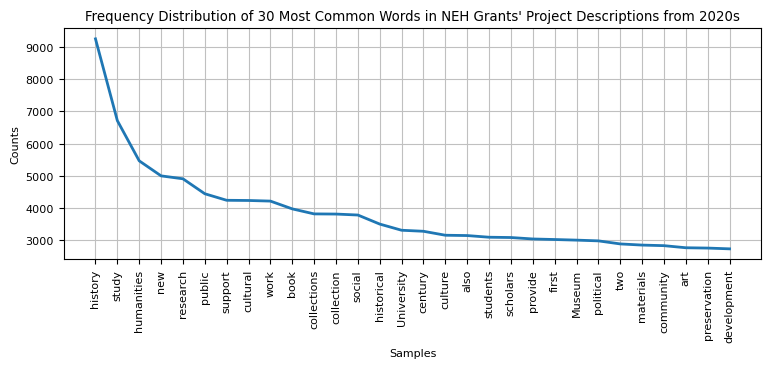

In [23]:
fdist_no_stopwords = FreqDist(no_stopwords)
# Customise the width and height of the plot
plt.figure(figsize = (9, 3))                
# Customise the font size of the title, axes names, and axes labels
plt.rc('font', size=8)
n_words = 30
plot_title = "Frequency Distribution of {n} Most Common Words in NEH Grants' Project Descriptions from {year}s".format(n=n_words, year=y)
fdist_no_stopwords.plot(n_words, title=plot_title)
plt.show()

Visualize the most common stems (words' roots) in the descriptions:

In [24]:
stemmer = nltk.PorterStemmer()
stems = [stemmer.stem(w) for w in no_stopwords]
print(stems[:10])

['grant', 'assist', 'conduct', 'five', 'experiment', 'interdisciplinari', 'cours', 'involv', 'human', 'b']


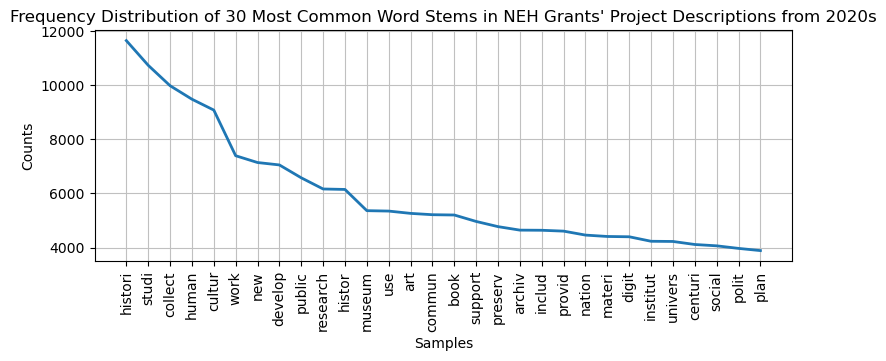

In [25]:
fdist_stems = FreqDist(stems)
# Customise the width and height of the plot
plt.figure(figsize = (9, 3))                
# Customise the font size of the title, axes names, and axes labels
plt.rc('font', size=10)
n_words = 30
plot_title = "Frequency Distribution of {n} Most Common Word Stems in NEH Grants' Project Descriptions from {year}s".format(n=n_words, year=y)
fdist_stems.plot(n_words, title=plot_title)
plt.show()

Save description word data by year as JSON for visualization in an Observable Notebook:

In [40]:
word_frequencies = utils.makeFreqDistJson(fdist_no_stopwords)
print(word_frequencies[0:3])

[{'word': 'grant', 'count': 2517}, {'word': 'assist', 'count': 380}, {'word': 'conducting', 'count': 107}]


In [41]:
with open(analysis_dir+"desc_word_frequencies.json", "w") as f:
    json.dump(word_frequencies, f)

In [38]:
stem_frequencies = utils.makeFreqDistJson(fdist_stems)
print(stem_frequencies[0:3])

[{'word': 'grant', 'count': 3819}, {'word': 'assist', 'count': 1124}, {'word': 'conduct', 'count': 1365}]


In [39]:
with open(analysis_dir+"desc_stem_frequencies.json", "w") as f:
    json.dump(stem_frequencies, f)